In [3]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *
from eibal import *

In [3]:
1+3

4

# Exploring the Structs with PDC Welch 
Here we will use the pre-computed spectral decompositions to plot the frequency range that most tracks E/I balance.
    According to the Voytek group this is the 30-50Hz range
    

In [4]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/connectivity'
SUB_DIR = 'Epat34'
sub_paths= glob.glob(os.path.join(DATA_DIR, SUB_DIR, "*.mat"))
sub_paths

['/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_14_FIAS_imcoh.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_23_FIAS_imcoh.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_25_FAS_imcoh.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_4_FIAS_imcoh.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_8_FIAS_imcoh.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_10_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_11_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_12_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_13_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_14_FIAS_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat34/Epat34_16_Focal,_unknown_awareness_P

In [5]:
tst_struct = load_mat(sub_paths[0])

In [11]:
psd_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,3.005548e-10,2.012459e-10,7.948901e-11,5.702138e-11,5.153079e-11,5.220942e-11,2.702256e-11,1.823885e-11,8.409413e-12,4.617876e-12,...,8.156912e-15,6.869705e-15,3.759503e-15,7.033004e-15,6.782518e-15,5.004685e-15,4.114395e-15,5.090861e-15,2.418627e-15,2.288888e-15
1,1.416419e-10,2.486360e-10,1.189588e-10,6.887853e-11,4.256545e-11,2.952332e-11,1.928847e-11,8.859181e-12,4.547376e-12,7.787929e-12,...,2.131649e-15,6.106397e-15,8.311024e-15,2.847467e-15,1.995680e-15,1.962303e-15,1.885408e-15,1.717352e-15,1.159568e-15,1.025705e-15
2,4.998616e-12,3.839536e-12,3.767820e-12,3.606265e-12,5.193425e-12,3.295224e-12,1.838381e-12,1.275352e-12,8.622466e-13,1.039414e-12,...,2.151121e-15,2.572359e-15,3.043713e-15,1.338239e-15,9.391763e-16,1.911954e-15,3.011325e-15,2.859071e-15,2.042518e-15,1.147071e-15
3,1.088107e-10,2.046684e-10,6.796995e-11,1.438366e-10,1.081601e-10,7.326911e-11,2.094703e-11,1.081494e-11,6.451754e-12,8.507205e-12,...,1.344865e-14,1.283796e-14,9.758406e-15,8.041940e-15,6.579388e-15,3.172238e-15,8.038029e-15,7.415210e-15,3.795024e-15,3.675287e-15
4,3.882822e-11,6.656592e-11,3.998343e-11,2.755100e-11,6.206280e-12,7.958392e-12,1.690918e-11,8.794918e-12,1.236457e-11,9.118530e-12,...,8.213737e-15,5.640528e-15,8.409594e-15,1.090773e-14,6.573513e-15,4.940298e-15,5.798672e-15,2.647302e-15,1.795725e-15,2.018325e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,9.923634e-12,1.899208e-11,2.014346e-11,8.287008e-12,3.030609e-11,2.078243e-11,8.496993e-12,5.440743e-12,9.843191e-12,1.064761e-11,...,6.096938e-15,1.262087e-14,9.369395e-15,6.662566e-15,7.519304e-15,9.215094e-15,5.560366e-15,4.813864e-15,3.853067e-15,1.726829e-15
104,7.276890e-12,1.861859e-11,1.661770e-11,1.325594e-11,1.722971e-11,1.578315e-11,6.678072e-12,1.376266e-11,2.989570e-11,2.192908e-11,...,3.511280e-15,9.452151e-15,1.222880e-14,3.322918e-15,8.077915e-15,4.333697e-15,3.624539e-15,2.090697e-15,1.577034e-15,1.232928e-15
105,6.496257e-12,1.500860e-11,2.208249e-11,2.635419e-11,1.009345e-11,6.946280e-12,6.549652e-12,8.020632e-12,1.933819e-11,2.152926e-11,...,6.948165e-15,9.128230e-15,3.685486e-15,3.324229e-15,2.531736e-15,1.917676e-15,4.362993e-15,2.968813e-15,1.289302e-15,1.410122e-15
106,3.600041e-12,9.355058e-12,1.239730e-11,1.264377e-11,1.239438e-11,7.821435e-12,4.224345e-12,1.788096e-11,4.806401e-11,4.303152e-11,...,1.812968e-15,2.947459e-15,3.655296e-15,1.804792e-15,1.552405e-15,1.109885e-15,4.790801e-16,4.731466e-16,6.281796e-16,4.484759e-16


(108, 150)


<Axes: xlabel='freqs', ylabel='50'>

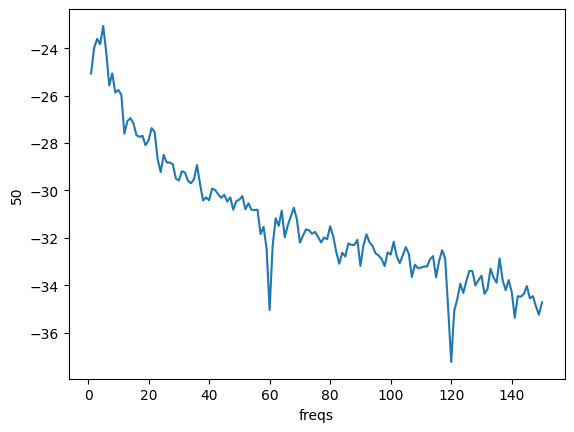

In [20]:
pwelch_all_windows = read_conn_struct(tst_struct, 'pdc','pwelch_all_windowed')
freqs = read_conn_struct(tst_struct, 'pdc','pwelch_freqs')

first_window = pwelch_all_windows[0,:,:]
first_window.shape
psd_df = pd.DataFrame(data=np.log(first_window.T))
psd_df['freqs'] = freqs
print(first_window.shape)
sns.lineplot(data=psd_df, x='freqs', y=50)

In [25]:
get_ei_slope(freqs, first_window[50,:])

np.float64(-0.0743445625577473)

In [ ]:
spectral_dfs = gen_global_peri_psd(sub_obj,spectral_keys)

In [ ]:
with sns.plotting_context("paper"):
    sns.lineplot(spectral_dfs, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)


In [ ]:
sub_obj['pdc']['seizure']['patID']

In [ ]:
for period in set(spectral_dfs.period):
    df = spectral_dfs[spectral_dfs.period == period]
    freqs = df.freq.values.reshape(-1,1)
    power = df.power.values.reshape(-1,1)
    slope = get_ei_slope(freqs, power)
    print(f"Period: {period} \nSlope: {slope}\n")

In [ ]:
len(sub_structs)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'gen')

In [ ]:
##Should be the same as above

with sns.plotting_context("paper"):
    sns.lineplot(peri_df, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'channel')

grp_df = peri_df.groupby(["freq",'labels','period']).mean().reset_index()

grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
grp_df

In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(grp_df,col='period',col_order=['interictal','pre','ictal','post']) 
        grid.map_dataframe(sns.lineplot, y='power',x='freq', hue='labels')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PSD on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_peri_psd.svg",transparent=True)

In [ ]:
contact_label = format_soz(sub_obj['pdc']['seizure']['soz_per_seizure'])
ei_df = get_reg_ei(sub_obj['pdc']['seizure'],spectral_keys,contact_label)
ei_df.period = ei_df.period.apply(lambda x : x.split("_")[-1])


In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(ei_df,col='period',col_order=['interictal','pre','post']) 
        grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_E_I_psd.svg",transparent=True)

In [ ]:
sub_list = [sub_path.split("/")[-2] for sub_path in sub_paths]
sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in sub_paths]

In [ ]:
sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))


In [ ]:
# from tqdm.notebook import tqdm
# sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))
# num_cores = 20
# ei_dfs = []
# count = 0
# for f_paths in tqdm(chunker(sub_paths, num_cores)):
#     structs = load_structs(f_paths,num_cores)
#     incl_inds = [i for i in range(len(structs)) if structs[i] != None]
#     structs = [structs[i] for i in incl_inds]

#     sub_list = [sub_path.split("/")[-2] for sub_path in f_paths]
#     sub_list = [sub_list[i] for i in incl_inds] #NOTE: god this is messy. TODO: fix struct chars for ID and sztype
#     sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in f_paths]
#     sz_list = [sz_list[i] for i in incl_inds]

#     res_dfs = get_reg_ei_para(structs, sub_list, sz_list, cores=num_cores)
#     ei_dfs.append(res_dfs)
#     count += 1
#     if count >5:
#         break
# ei_dfs = pd.concat(ei_dfs)


## Comparing E/I Distributions 

In [5]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/'
ei_files = glob.glob(os.path.join(DATA_DIR, "ei_bal_*pat*.csv"))
print(f"Total of {len(ei_files)} to load")


Total of 43 to load


In [6]:
ei_dfs = []
for f in ei_files:
    df = pd.read_csv(f).rename(columns={"window_designation":"window_designations"})
    df = center_onset(df)
    ei_dfs.append(df)
#should drop any of the mid-seizure periods that were not sampled and whole events that 
# were not able to be centered
ei_dfs = pd.concat(ei_dfs).dropna()
print(f"Successfully loaded and centered {len(set(ei_dfs.patID))}")

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['win_sz_centered'] = center_windows(event_df.window_designations, event_df.period.values,center_designations=center_designations)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['sz_end'] = get_sz_end(event_df)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/c

Successfully loaded and centered 42


In [7]:
ei_dfs = ei_dfs.dropna()

In [8]:
def resample_regions(res_df, reg_col):
    channel_counts = Counter(res_df[reg_col])
    n_samps = min(channel_counts.values())
    pz_df = res_df[res_df[reg_col] == 'PZ'].sample(n=n_samps, replace=True)

    soz_df = res_df[res_df[reg_col] == 'SOZ'].sample(n=n_samps, replace=True)

    niz_df = res_df[res_df[reg_col] == 'NIZ'].sample(n=n_samps, replace=True)

    return pd.concat([pz_df, soz_df, niz_df])

def get_stats_df(res_df, grouping_col='win_label'):
    stats_df = pd.DataFrame(columns=['p_val',grouping_col])
    for i, period in enumerate(set(res_df[grouping_col])):
        per_df = res_df[res_df[grouping_col] == period]
        a = per_df[per_df.region == 'PZ'].e_i
        b = per_df[per_df.region == 'SOZ'].e_i
        c = per_df[per_df.region == 'NIZ'].e_i
        F, p = f_oneway(a, b, c)
        stats_df.loc[i] = [p, period]

    return stats_df

In [9]:
#stats_df.groupby('period').mean()
ei_dfs = ei_dfs.dropna()
set(ei_dfs.win_label)

{'early_ictal',
 'early_post_ictal',
 'ictal',
 'interictal',
 'late_ictal',
 'post_ictal',
 'pre_ictal'}

In [11]:
stats_df = []
run_count = 0
for i in range(10):
    resamp_dfs = resample_regions(ei_dfs, 'region')
    grp_df= resamp_dfs[['e_i', 'region', 'win_label','patID']].groupby(['patID','region','win_label']).mean().reset_index()
 #   grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
    run_count +=1
    df = get_stats_df(grp_df)
    df['run'] = run_count
    stats_df.append(df)
stats_df = pd.concat(stats_df)


In [26]:
stats_df.groupby('win_label').mean()

,p_val,run
win_label,,
early_ictal,0.694300,500.5
early_post_ictal,0.491998,500.5
ictal,0.008464,500.5
interictal,0.047403,500.5
late_ictal,0.078623,500.5
post_ictal,0.739496,500.5
pre_ictal,0.152888,500.5


In [10]:

# with sns.plotting_context("paper"):
#     with sns.color_palette("flare"):
#         grid = sns.FacetGrid(grp_df,col='win_label',col_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal']) 
#         grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
#         grid.add_legend()
#         grid.set_ylabels("Excitation Inhibition")
#         grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
#         plt.savefig("../viz/peri_full_E_I_psd.svg",transparent=True)

In [12]:
resamp_dfs

,e_i,region,period,window_designations,patID,sz_type,eventID,win_sz_centered,sz_end,win_sz_st_end,win_label
93938,-0.065538,PZ,1043,2.0_2.0_2.0,Epat30,FBTC,1,448.0,137.0,340.0,post_ictal
80335,-0.055092,PZ,694,2.0_2.0_2.0,Spat13,"Focal, unknown awareness",2,99.0,32.0,93.0,post_ictal
4511087,-0.046635,PZ,1220,2.0_2.0_2.0,Epat26,FIAS,9,625.0,97.0,557.0,post_ictal
404888,-0.062920,PZ,140,0.0_0.0_0.0,Epat26,FAS,15,-455.0,105.0,-455.0,interictal
3293732,-0.112956,PZ,1063,2.0_2.0_2.0,Epat26,FIAS,44,468.0,101.0,396.0,post_ictal
...,...,...,...,...,...,...,...,...,...,...,...
16328,-0.026187,NIZ,173,0.0_0.0_0.0,Epat21,FIAS,1,-422.0,101.0,-422.0,interictal
150512,-0.034776,NIZ,698,2.0_2.0_2.0,Spat06,"Focal, unknown awareness",2,103.0,74.0,58.0,early_post_ictal
181207,-0.084689,NIZ,1264,2.0_2.0_2.0,Epat19,FAS,1,669.0,125.0,571.0,post_ictal
109702,-0.085339,NIZ,937,2.0_2.0_2.0,Epat24,FBTC,16,342.0,193.0,176.0,post_ictal


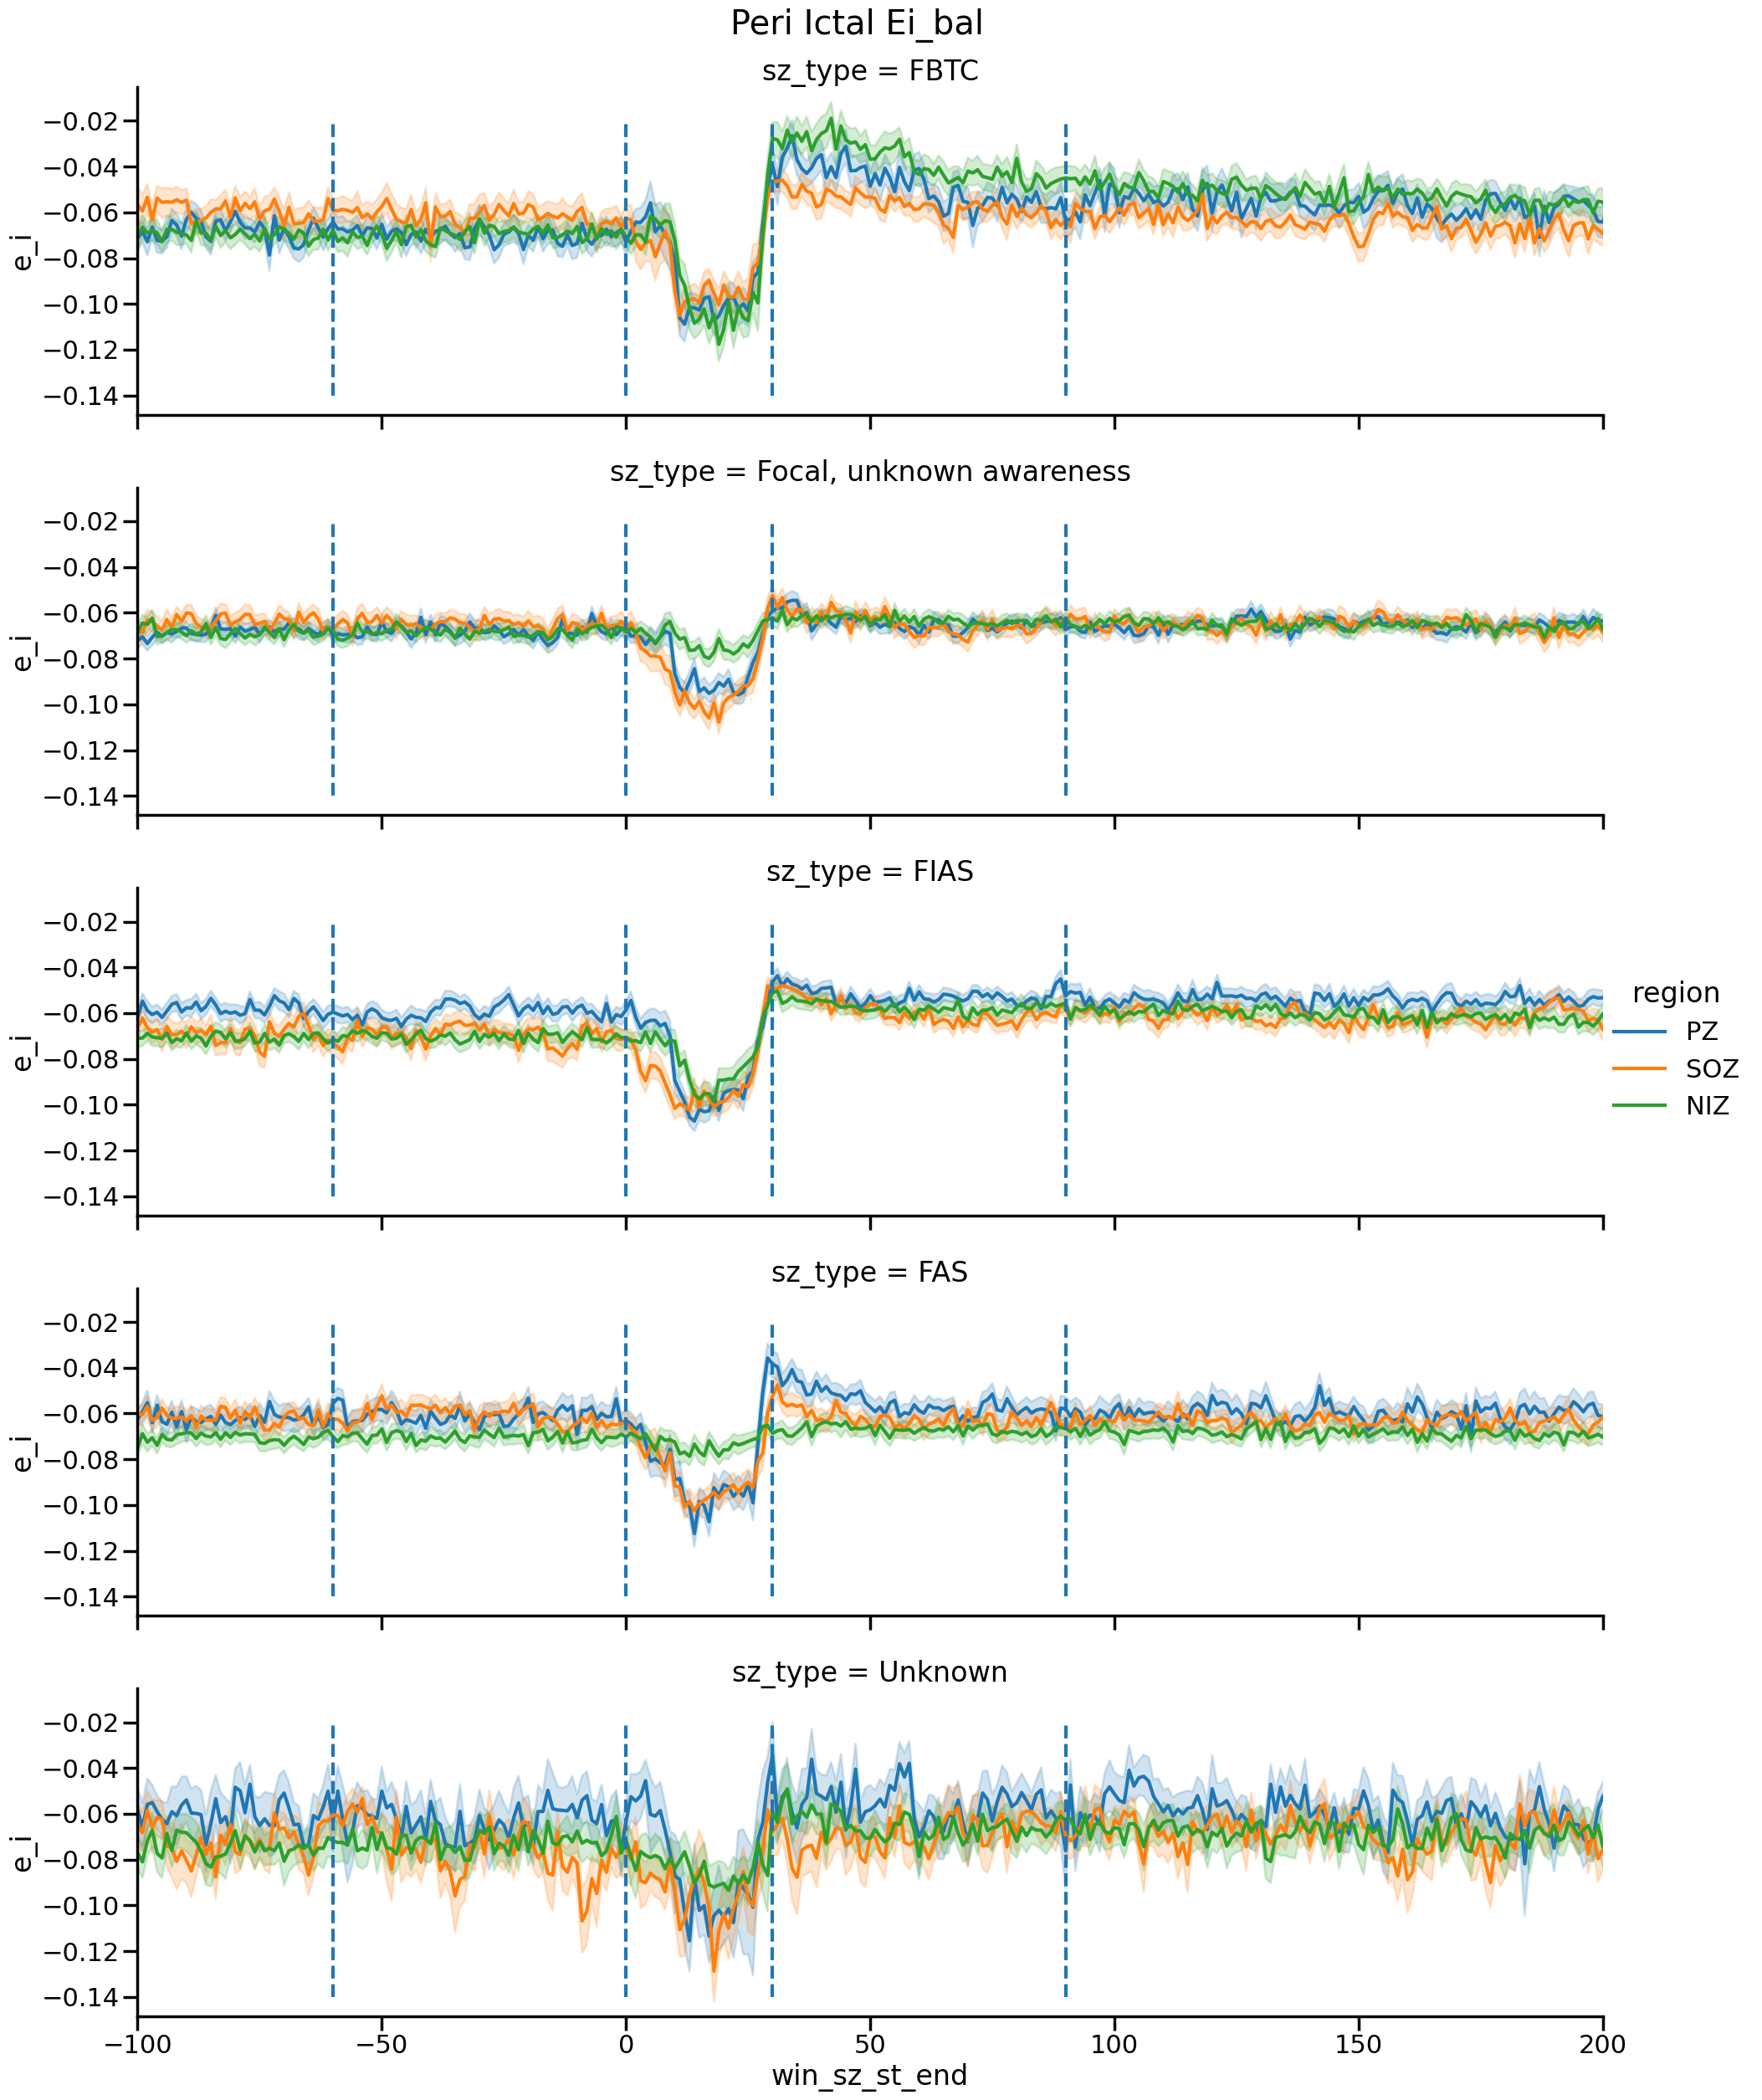

In [15]:
with sns.plotting_context("poster"):
    with sns.color_palette("tab10"):
        plot_df = resamp_dfs.dropna()
        #grid = sns.FacetGrid(plot_df, row='sz_type',aspect=4) 
        grid = sns.relplot(data= plot_df,
                           x='win_sz_st_end',
                           y="e_i",
                           row='sz_type',
                           hue='region',
                           aspect=4,
                           kind='line')
 #       grid.map_dataframe(sns.lineplot, y='e_i',x='win_sz_st_end', hue='region')
        #grid.add_legend()
        axes = grid.axes
        for ax in axes:
            ax[0].vlines(x = [-60,0, 30, 90], ymin = -.14, ymax = -.02,linestyles ='dashed')
        plt.xlim(-100, 200)
        grid.figure.suptitle("Peri Ictal Ei_bal",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_ei_bal.pdf",transparent=True)

In [ ]:
grp_df[['region','period','e_i']].groupby(['region','period']).mean()